In [2]:
import csv
import os

import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx

data_dir = '../data/'
trace_data = os.path.join(data_dir, 'training_data', '2020_05_04', 'trace')

In [3]:
filenames = os.listdir(trace_data)
trace_df = [pd.read_csv(trace_data + os.sep + f) for f in filenames]

In [39]:
traceIds = [df['traceId'].unique() for df in trace_df]    
traceIds = np.unique(np.concatenate(traceIds))

In [60]:
# columns=['startTime','elapsedTime','success','traceId','id','pid','cmdb_id','serviceName','dsName','callType']

##############
traceId = np.random.choice(traceIds) # Test for now
##############

single_trace = pd.concat([df[df['traceId'] == traceId] for df in trace_df])
single_trace.head(100)

,callType,startTime,elapsedTime,success,traceId,id,pid,cmdb_id,serviceName,dsName
3554035,CSF,1588606141500,1246.0,True,89089171e04e04315830,8949c171e04e043c5833,6dcbf171e04e04315831,os_021,csf_001,NaN
3554068,CSF,1588606141747,93.0,True,89089171e04e04315830,03919171e04e05335928,21b48171e04e04645889,docker_003,csf_002,NaN
3554086,CSF,1588606141940,101.0,True,89089171e04e04315830,1d401171e04e05f35950,21b48171e04e04645889,docker_003,csf_003,NaN
3554098,CSF,1588606142044,97.0,True,89089171e04e04315830,04bbc171e04e065b5974,21b48171e04e04645889,docker_003,csf_004,NaN
3554104,CSF,1588606142147,122.0,True,89089171e04e04315830,73caf171e04e06c16010,21b48171e04e04645889,docker_003,csf_005,NaN
710813,FlyRemote,1588606141740,5.0,True,89089171e04e04315830,49523171e04e052c5910,21b48171e04e04645889,docker_003,fly_remote_001,NaN
18491672,JDBC,1588606141767,3.0,True,89089171e04e04315830,4f1a6171e04e05477771,6ccd5171e04e05477768,docker_006,NaN,db_003
18491675,JDBC,1588606141771,2.0,True,89089171e04e04315830,8a67f171e04e054b7774,6ccd5171e04e05477768,docker_006,NaN,db_003
18491720,JDBC,1588606141951,2.0,True,89089171e04e04315830,9bd3e171e04e05ff7834,2368d171e04e05ff7831,docker_006,NaN,db_003
18491722,JDBC,1588606141955,3.0,True,89089171e04e04315830,7721e171e04e06037837,2368d171e04e05ff7831,docker_006,NaN,db_003


In [58]:
G = nx.Graph()
G = nx.from_pandas_edgelist(single_trace, source='pid', target='id')

print(len(list(G.nodes)))
print(len(list(G.edges)))

59
58


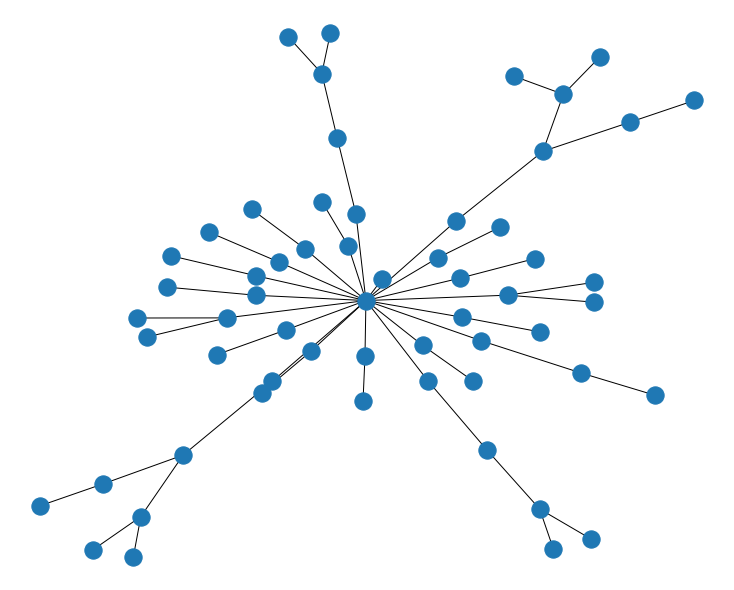

In [59]:
from matplotlib.pyplot import figure
figure(figsize=(10, 8))
nx.draw(G, with_labels=False)